<a href="https://colab.research.google.com/github/emakhankov/stepik_samsung_computer_vision/blob/master/stepik_samsung_computer_vision_version_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# By Evgeny Makhankov

In [0]:
# Гипотеза что сеть разпознающее флюораграфические снимки, возможно будет хорошо справляться с обнаружением грязной посуды

# Примеры сети
# https://www.kaggle.com/curiousprogrammer/chest-x-ray-image-classification-tf-hub-resnet50
# https://www.kaggle.com/curiousprogrammer/chest-x-ray-keras-vgg19-transfer-learning

In [0]:
# Инсталлируем tensorflow, т.к. в нем есть предобученная моделль ResNet50V2
pip install tensorflow==2.0

     |████████████████████████████████| 86.3MB 102kB/s 
     |████████████████████████████████| 450kB 42.0MB/s 
     |████████████████████████████████| 3.8MB 39.4MB/s 
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [0]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os # Работа с файлами
import gc # Сбоока мусора, т.к. без принудительной сборки колаб вылетал

#File Operation libraries
import glob
from pathlib import Path

#Visualisation Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix

#Image Transformation Libraries
import cv2
from imgaug import augmenters as iaa # Пакет по аугментации

In [0]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"emakhankov","key":"59b0d26b9b7ebc36e2eb7bc397f04a87"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [0]:
!kaggle competitions download -c platesv2

 70% 33.0M/47.1M [00:01<00:01, 14.5MB/s]
100% 47.1M/47.1M [00:01<00:00, 39.0MB/s]
  0% 0.00/8.00k [00:00<?, ?B/s]
100% 8.00k/8.00k [00:00<00:00, 8.32MB/s]


In [0]:
!unzip plates.zip

Archive:  plates.zip
   creating: plates/
  inflating: plates/.DS_Store        
   creating: __MACOSX/
   creating: __MACOSX/plates/
  inflating: __MACOSX/plates/._.DS_Store  
   creating: plates/test/
  inflating: plates/test/0071.jpg    
  inflating: plates/test/0717.jpg    
  inflating: plates/test/0703.jpg    
  inflating: plates/test/0065.jpg    
  inflating: plates/test/0059.jpg    
  inflating: plates/test/0515.jpg    
  inflating: plates/test/0273.jpg    
  inflating: plates/test/0267.jpg    
  inflating: plates/test/0501.jpg    
  inflating: plates/test/0529.jpg    
  inflating: plates/test/0298.jpg    
  inflating: plates/test/0461.jpg    
  inflating: plates/test/0307.jpg    
  inflating: plates/test/0313.jpg    
  inflating: plates/test/0475.jpg    
  inflating: plates/test/0449.jpg    
  inflating: plates/test/0105.jpg    
  inflating: plates/test/0663.jpg    
  inflating: plates/test/0677.jpg    
  inflating: plates/test/0111.jpg    
  inflating: plates/test/0139.jpg    


In [0]:
base_dir = "plates/"
train_dir = base_dir+'train/'
test_dir = base_dir+'test/'
val_dir = base_dir+'val/'

In [0]:
#Разбивка данных на train и val datasets
#Изначально для сети ResNet50V2 хороший результат (0.87) был получен при i % 6, потом доучивая сеть с увеличением train и даже с полной отказом от val - выше результата не дало.
#Последная сеть ResNet50V2 + Inception уже валидировалась по аугментированной обучающей выборке

def get_df(path,shuffle = True,validation = False):
    lst = []
    cleaned_dir = Path(path + "cleaned")
    dirty_dir = Path(path + "dirty")
    cleaned_data = cleaned_dir.glob("*.jpg")
    dirty_data = dirty_dir.glob("*.jpg")
    
    i = 0;
    for fname in cleaned_data:
      i += 1;
      #if (validation == True) and (i % 12 == 0) or (validation == False) and (i % 12 != 0) :
      if True: #Валидировать будем по аугментированным данным
          lst.append((fname, 0))
    i = 0;
    for fname in dirty_data:
      i += 1;
      if True: 
      #if (validation == True) and (i % 12 == 0) or (validation == False) and (i % 12 != 0) :
        lst.append((fname, 1))
    df = pd.DataFrame(lst, columns=['Image', 'Label'], index=None)
    s = np.arange(df.shape[0])
    if shuffle:
      np.random.shuffle(s)
    df = df.iloc[s,:].reset_index(drop=True)
    return df

In [0]:
df_train = get_df(train_dir)
df_train = pd.concat([df_train,df_train,df_train])  # Увеличим обучающую выборку в 3 раза, потом добросить проблемные элементы, чтобы они в общей массе были не столь значимы
df_val = get_df(train_dir,False,True)

In [0]:
# ResNet50V2 + Inception добавляление 3-х картинк - металлическая кастюля с затемненным дном. (часто определяется как грязная, причем глазами тяжело было понять это прилипшее кофе или тень)
#lst = []
#lst.append((Path("plates/test/0370.jpg"), 0))
#lst.append((Path("plates/test/0178.jpg"), 0))
#lst.append((Path("plates/test/0701.jpg"), 0))
#df = pd.DataFrame(lst, columns=['Image', 'Label'], index=None)
#df = df.reset_index(drop=True)
#df_train = pd.concat([df_train,df])

In [0]:
df_train.head(3)

,Image,Label
0,plates/train/dirty/0015.jpg,1
1,plates/train/dirty/0016.jpg,1
2,plates/train/dirty/0011.jpg,1


In [0]:
#Зачитать картинку
def transform_image(img_item):
    img = cv2.resize(img_item, (224, 224))
    #cv2 reads image in BGR format. Let's convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img  

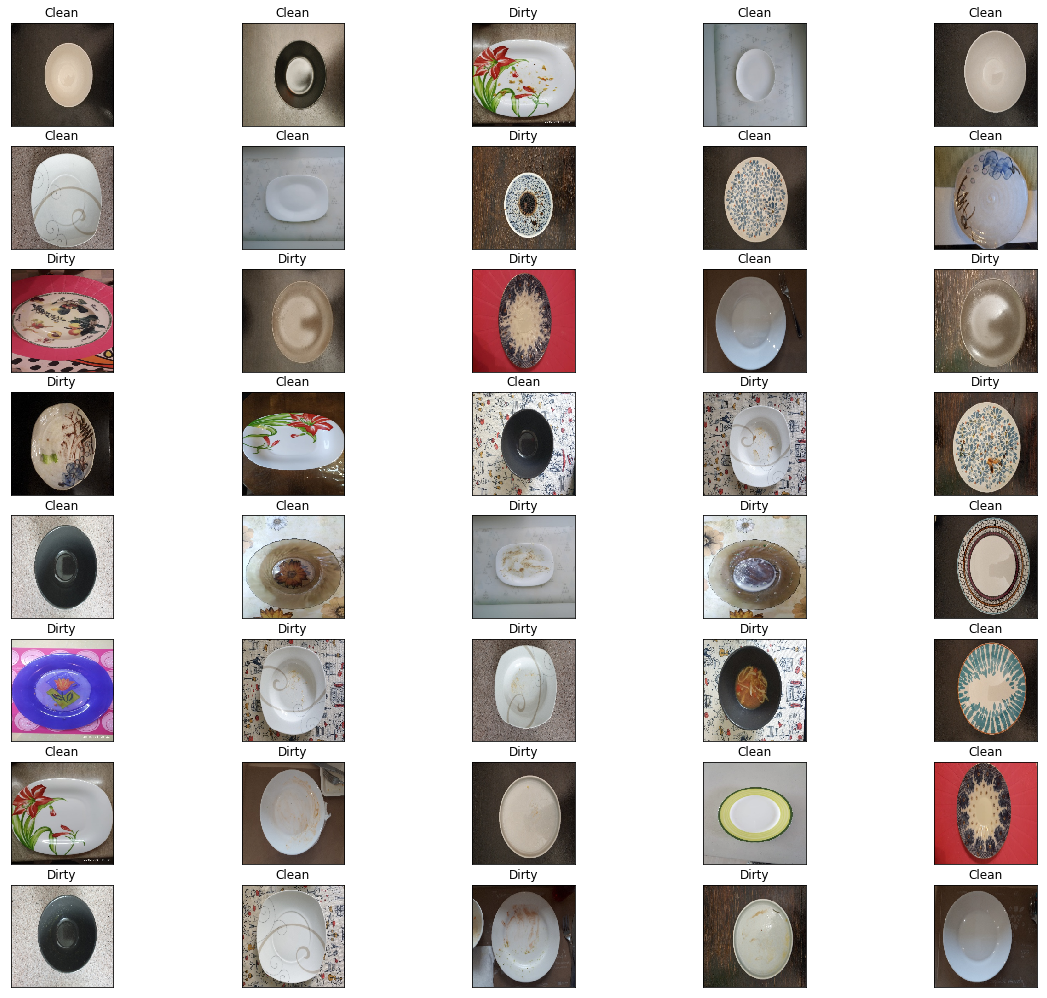

In [0]:
fig, ax = plt.subplots(figsize=(20, 20))
for i in range(40):
    plt.subplot(9, 5, i+1)
    img = transform_image(cv2.imread(str(df_train.iloc[i, 0])))
    plt.imshow(img)
    if df_train.iloc[i, 1] == 0:
        plt.title('Clean')
    else:
        plt.title('Dirty')
    plt.xticks([])
    plt.yticks([])
plt.show()

In [0]:
 

def augment_image(img_list):
    #sometimes = lambda aug: iaa.Sometimes(0.5, aug)
    seq = iaa.Sequential([        
    #seq = iaa.OneOf([
        iaa.Sometimes(0.99,iaa.Crop(percent=(0.05, 0.15))),
        iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            rotate=(-45, 45),
            shear=(-16, 16),
        ),
        #iaa.Sometimes(0.5,iaa.Crop(percent=(0, 0.2))),
        iaa.Invert(0.1, per_channel=True),
        iaa.Flipud(0.3),
        iaa.Fliplr(0.5),
        iaa.Sometimes(0.5, iaa.OneOf([
                                        iaa.EdgeDetect(alpha=(0, 0.7)),
                                        iaa.DirectedEdgeDetect(
                                        alpha=(0, 0.7), direction=(0.0, 1.0)
                    ),
                ])),
        
        iaa.Sometimes(0.1,iaa.ElasticTransformation(alpha=(0.9, 1.2), sigma=0.25)),
        iaa.Sometimes(0.1,iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5)),
        iaa.Sometimes(0.05, iaa.Grayscale(alpha=(0.0, 0.5))),
        iaa.Sometimes(0.3,iaa.Multiply((0.8, 1.2)))
    ])
    return seq.augment_image(img_list)



In [0]:
def transform_augment_batch(img_path_list, label_list, is_augment=False, is_only_augment = False, augment_k = 3):
    img_list = []
    l_list = []
    for i in range(len(img_path_list)):
      img_list.append(transform_image(cv2.imread(str(img_path_list[i]))))
      l_list.append(label_list[i]) 
          
    n = len(img_list)
    if is_augment: # Увеличение в 32 раза к исходным добавляем крученые
      for mm in range(augment_k):
        for i in range(n):
            img = img_list[i]
            img = augment_image(img)
            img_list.append(img)
            l_list.append(label_list[i]) 
      img_list = np.array(img_list)
      label_list = np.array(l_list)
      
      if is_only_augment:
        img_list = img_list[n:]
        label_list = label_list[n:]
        
    return img_list, label_list,   tf.keras.applications.inception_v3.preprocess_input(img_list), tf.keras.applications.resnet_v2.preprocess_input(img_list), tf.keras.applications.vgg19.preprocess_input(img_list)

In [0]:
tf.keras.applications.resnet_v2.preprocess_input(np.array([[200,100,150]])), tf.keras.applications.inception_v3.preprocess_input(np.array([[200,100,150]])), tf.keras.applications.vgg19.preprocess_input(np.array([[200,100,150]]))

(array([[ 0.5686275 , -0.21568626,  0.17647064]], dtype=float32),
 array([[ 0.5686275 , -0.21568626,  0.17647064]], dtype=float32),
 array([[ 46.060997, -16.779   ,  76.32    ]], dtype=float32))

In [0]:
tf.keras.applications.resnet_v2.preprocess_input(np.array([[200,100,150]]) / 255.0)

array([[-0.99384852, -0.99692426, -0.99538639]])

In [0]:
# Получить валидационную выборку. Все элементы тренировочкой но чисто аугментированные
#val_labels = np.array(df_val.iloc[:, 1]).reshape((df_val.shape[0], 1))
val_images, val_labels , val_images_inception, val_images_resnet, val_images_vgg = transform_augment_batch(df_val.iloc[:, 0], df_val.iloc[:, 1], True, True, 1)
val_images = np.array(val_images)
val_images_inception = np.array(val_images_inception)
val_images_resnet = np.array(val_images_resnet)
val_images_vgg = np.array(val_images_vgg)
#val_images = val_images / 255.0
#val_images = val_images_resnet #/ 255.0

In [0]:
def CreateResInceptModel():
  
  resnet = tf.keras.applications.ResNet50V2(weights='imagenet', 
                  include_top=False, 
                  input_shape=(224, 224,  3))
  resnet.trainable = False


  inception = tf.keras.applications.InceptionV3(weights='imagenet', 
                  include_top=False, 
                  input_shape=(224, 224,  3))
  inception.trainable = False
  
  vgg = tf.keras.applications.VGG19(weights='imagenet', 
                  include_top=False, 
                  input_shape=(224, 224,  3))
  vgg.trainable = False
  
  
  inp1 = tf.keras.layers.Input((224, 224,  3))
  inp2 = tf.keras.layers.Input((224, 224,  3))
  inp3 = tf.keras.layers.Input((224, 224,  3))
 
  ex1 = inception(inp1)
  ex2 = resnet(inp2)
  ex3 = vgg(inp3)
  
  #b1 = tf.keras.layers.Flatten()(ex1)
  b1 = tf.keras.layers.GlobalAveragePooling2D()(ex1)
  b2 = tf.keras.layers.Flatten()(ex2)
  b3 = tf.keras.layers.Flatten()(ex3)
  bc = tf.keras.layers.Concatenate()([b1,b2, b3])
  b4 = tf.keras.layers.Dense(1000, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00001))(bc)
  b4d = tf.keras.layers.Dropout(0.2)(b4)
  b5 = tf.keras.layers.Dense(10, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.00001))(b4d)
  b6 = tf.keras.layers.Dense(1, activation='sigmoid')(b5)
  model = tf.keras.Model(inputs=(inp1,inp2,inp3), outputs=b6)
  
  return model


In [0]:
def CreateResInceptModel2():
  
  resnet = tf.keras.applications.ResNet50V2(weights='imagenet', 
                  include_top=False, 
                  input_shape=(224, 224,  3))
  resnet.trainable = False


  inception = tf.keras.applications.InceptionV3(weights='imagenet', 
                  include_top=False, 
                  input_shape=(224, 224,  3))
  inception.trainable = False
  
  vgg = tf.keras.applications.VGG19(weights='imagenet', 
                  include_top=False, 
                  input_shape=(224, 224,  3))
  vgg.trainable = False
  
  
  inp1 = tf.keras.layers.Input((224, 224,  3))
  inp2 = tf.keras.layers.Input((224, 224,  3))
  inp3 = tf.keras.layers.Input((224, 224,  3))
 
  ex1 = inception(inp1)
  ex2 = resnet(inp2)
  ex3 = vgg(inp3)
  
  #b1 = tf.keras.layers.Flatten()(ex1)
  b1 = tf.keras.layers.GlobalAveragePooling2D()(ex1)
  b11 = tf.keras.layers.Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.000001))(b1)
  b2 = tf.keras.layers.Flatten()(ex2)
  b21 = tf.keras.layers.Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.000001))(b2)
  b3 = tf.keras.layers.Flatten()(ex3)
  b31 = tf.keras.layers.Dense(100, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.000001))(b3)
  bc = tf.keras.layers.Concatenate()([b11,b21, b31])
  bcd = tf.keras.layers.Dropout(0.1)(bc)
  b5 = tf.keras.layers.Dense(25, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.000001))(bcd)
  b6 = tf.keras.layers.Dense(1, activation='sigmoid')(b5)
  model = tf.keras.Model(inputs=(inp1,inp2,inp3), outputs=b6)
  
  return model

In [0]:
  modelinceptionresnet = CreateResInceptModel2()
  modelinceptionresnet.summary()

80142336/80134624 [==============================] - 7s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 5, 5, 2048)   21802784    input_4[0][0]                    
_____________________________

In [0]:
opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
modelinceptionresnet.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])


In [0]:
start_epoch = 1
gc.collect()

0

In [0]:
print(len(df_train))

120


In [0]:
gc.collect()
#batch_size=len(df_train)
batch_size = 120
epochs = 1000
current_epoch = start_epoch - 1

for epoch in range(epochs):
    
    
    current_epoch += 1 
    
    
    if current_epoch == 7:
      lr = 0.0001
      opt = tf.keras.optimizers.Adam(lr=lr, decay=1e-6)
      modelinceptionresnet.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    if current_epoch == 12:
      lr = 0.00001
      opt = tf.keras.optimizers.Adam(lr=lr, decay=1e-6)
      modelinceptionresnet.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    if current_epoch == 20:
      lr = 0.000001
      opt = tf.keras.optimizers.Adam(lr=lr, decay=1e-6)
      modelinceptionresnet.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
      
      
    
                        
    s = np.arange(df_train.shape[0])
  
    np.random.shuffle(s)
  
    X_dev = df_train.iloc[s, 0]
    Y_dev = df_train.iloc[s, 1]
    X_dev = np.array(X_dev)
    Y_dev = np.array(Y_dev)
    
    start_index = 0
    counter = 0
    acc_ehoch = []
    while start_index < len(X_dev):
        if start_index+batch_size <= len(X_dev):
            end_index = start_index+batch_size
        else:
            end_index = len(X_dev)
            
        
        #Select image paths in batches
        x_dev = X_dev[start_index:end_index]
        y_dev = Y_dev[start_index:end_index]
        
        start_index = end_index
        
        
        #Transform images and augment
        x_dev, y_dev, x_dev_inception, x_dev_resnet, x_dev_vgg = transform_augment_batch(x_dev, y_dev, True)
        y_dev = y_dev.reshape((len(y_dev), 1))
        
        #Normalize
        x_dev = x_dev / 255.0
               
        gc.collect()
        
        print('Текущая эпоха', current_epoch)
        history = modelinceptionresnet.fit((x_dev_inception, x_dev_resnet, x_dev_vgg), y_dev, validation_data = ((val_images_inception,val_images_resnet, val_images_vgg), val_labels))
        
        if history.history['accuracy'][0] >= 0.95 or history.history['val_accuracy'][0] > 0.95:
          print('acc= ',history.history['accuracy'])
          print('val_acc= ',history.history['val_accuracy'])
          modelinceptionresnet.save('InceptionResnetVGG_acc_{:.4f}_acc_val_{:.4f}_loss{:.4f}_loss_val{:.4f}.h5'.format(history.history['accuracy'][0], history.history['val_accuracy'][0], history.history['loss'][0], history.history['val_loss'][0]))
          #modelresnet.save('/content/drive/My Drive/ForColab/PyTorchExam/resnet_v2_acc_{:.4f}_acc_val_{:.4f}_loss{:.4f}_loss_val{:.4f}.h5'.format(history.history['accuracy'][0], history.history['val_accuracy'][0], history.history['loss'][0], history.history['val_loss'][0]))
          
        
          
     

Текущая эпоха 1
Train on 480 samples, validate on 40 samples
480/480 [==============================] - 601s 1s/sample - loss: 2.7053 - accuracy: 0.6583 - val_loss: 0.6132 - val_accuracy: 0.7750
Текущая эпоха 2
Train on 480 samples, validate on 40 samples
480/480 [==============================] - 577s 1s/sample - loss: 0.5286 - accuracy: 0.8521 - val_loss: 0.5956 - val_accuracy: 0.7500
Текущая эпоха 3
Train on 480 samples, validate on 40 samples
480/480 [==============================] - 592s 1s/sample - loss: 0.3396 - accuracy: 0.8833 - val_loss: 0.3516 - val_accuracy: 0.8000
Текущая эпоха 4
Train on 480 samples, validate on 40 samples
480/480 [==============================] - 586s 1s/sample - loss: 0.2537 - accuracy: 0.9062 - val_loss: 0.4308 - val_accuracy: 0.8000
Текущая эпоха 5
Train on 480 samples, validate on 40 samples
480/480 [==============================] - 576s 1s/sample - loss: 0.1459 - accuracy: 0.9479 - val_loss: 0.3531 - val_accuracy: 0.9250
Текущая эпоха 6
Train on 

KeyboardInterrupt: ignored

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp /content/resnet_v2_acc_0.9812_acc_val_0.9250_loss0.1019_loss_val0.5960.h5 '/content/drive/My Drive/ForColab/PyTorchExam/InseptionResnetVGG_acc_0.9812_acc_val_0.9250_loss0.1019_loss_val0.5960.h5'

In [0]:
def augment_test_image(img_list):
    seq = iaa.Sequential([        
          iaa.Crop(percent=(0.05))
    ])
    return seq.augment_image(img_list)

In [0]:
def get_df_test(path):
    lst = []
    test_dir = Path(path)
    test_data = test_dir.glob("*.jpg")
    
    i = 0;
    for fname in test_data:
      lst.append((fname, 0))
    df = pd.DataFrame(lst, columns=['Image','Label'], index=None)
    s = np.arange(df.shape[0])
    df = df.iloc[s,:].reset_index(drop=True)
    return df
df_test = get_df_test(test_dir)

In [0]:
gc.collect()
img_list = []
l_list = []
img_path_list = df_test.iloc[:, 0]
for i in range(len(df_test)):
  img_list.append(augment_test_image(transform_image(cv2.imread(str(img_path_list[i])))))
  
n = len(img_list)
img_list = np.array(img_list)

test_images = img_list
test_images = np.array(test_images)

img_list_inception = tf.keras.applications.inception_v3.preprocess_input(test_images)
img_list_resnet = tf.keras.applications.resnet_v2.preprocess_input(test_images)
img_list_vgg =  tf.keras.applications.vgg19.preprocess_input(test_images)



In [0]:
#file_model_submit = '/content/resnet_v2_acc_0.9521_acc_val_0.9250_loss0.1481_loss_val0.2750.h5'  # 0.92607  рег 0.000001 dropout 0.05  100 20   - Тут классно что val практически сооответствовал тесту
#file_model_submit = '/content/resnet_v2_acc_1.0000_acc_val_0.9000_loss0.0013_loss_val0.3561.h5'  # 0.90053

#file_model_submit = '/content/resnet_v2_acc_1.0000_acc_val_0.7500_loss0.0059_loss_val1.5229.h5'

#file_model_submit = 'resnet_v2_acc_0.9604_acc_val_0.8750_loss0.1231_loss_val0.2618.h5'  # 0.80  100 25


#file_model_submit = '/content/resnet_v2_acc_0.9812_acc_val_0.9250_loss0.1019_loss_val0.5960.h5' # 0.85215


#file_model_submit = '/content/resnet_v2_acc_0.9792_acc_val_0.9250_loss0.1144_loss_val0.5925.h5' # 0.85215

#file_model_submit = '/content/resnet_v2_acc_0.9708_acc_val_0.9250_loss0.0969_loss_val0.5836.h5' # 0.85349

#file_model_submit = '/content/resnet_v2_acc_0.9875_acc_val_0.9250_loss0.0533_loss_val0.2916.h5'


file_model_submit = '/content/InceptionResnetVGG_acc_0.9646_acc_val_0.9250_loss0.1209_loss_val0.3002.h5'

In [0]:
model_submit = tf.keras.models.load_model(file_model_submit) 
model_submit.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 5, 5, 2048)   21802784    input_4[0][0]                    
______________________________________________________________________________________________

In [0]:
test_predictions = model_submit.predict((img_list_inception, img_list_resnet, img_list_vgg))

In [0]:
submission_df = pd.DataFrame(columns=['id', 'label'])
for i in range(len(df_test)):
  submission_df.loc[i]= [str(df_test.iloc[i, 0]),test_predictions[i][0]]
submission_df.head(n=10)

,id,label
0,plates/test/0353.jpg,0.000102
1,plates/test/0423.jpg,0.938171
2,plates/test/0645.jpg,1.000000
3,plates/test/0089.jpg,1.000000
4,plates/test/0281.jpg,1.000000
5,plates/test/0668.jpg,1.000000
6,plates/test/0435.jpg,0.991496
7,plates/test/0610.jpg,1.000000
8,plates/test/0492.jpg,0.956527
9,plates/test/0731.jpg,0.000046


In [0]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('plates/test/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=10)

,label
id,
0353,cleaned
0423,dirty
0645,dirty
0089,dirty
0281,dirty
0668,dirty
0435,dirty
0610,dirty
0492,dirty


In [0]:
submission_df.to_csv('submission.csv')

In [0]:
!kaggle competitions submit -c platesv2 -m "InceptionResnetVGG_acc_0.9646_acc_val_0.9250_loss0.1209_loss_val0.3002" -f submission.csv

100% 8.43k/8.43k [00:10<00:00, 806B/s]
Successfully submitted to Cleaned vs Dirty V2